In [1]:
import cv2
import numpy as np

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_point = (int(start_point[0] * width), int(start_point[1] * height))
    end_point = (int(end_point[0] * width), int(end_point[1] * height))

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define region of interest (ROI)
    roi_top = max(0, min(start_point[1], end_point[1]) - 20)
    roi_bottom = min(height, max(start_point[1], end_point[1]) + 20)
    roi = gray[roi_top:roi_bottom, :]

    # Apply threshold to isolate white stripes
    _, thresh = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Find leftmost and rightmost points of all contours
    left_x = width
    right_x = 0
    for contour in contours:
        x, _, w, _ = cv2.boundingRect(contour)
        left_x = min(left_x, x)
        right_x = max(right_x, x + w)

    # Adjust for ROI offset
    left_x += 0
    right_x += 0

    # Create boundary points
    top_left = (left_x, start_point[1])
    top_right = (right_x, start_point[1])
    bottom_left = (left_x, end_point[1])
    bottom_right = (right_x, end_point[1])

    return [top_left, top_right, bottom_right, bottom_left]


In [2]:
# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")

In [3]:
import cv2
import numpy as np

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_y = int(start_point[1] * height)
    end_y = int(end_point[1] * height)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(gray)
    # Create a horizontal edge detection filter
    filter_width = 51  # Adjust this based on your image size and crosswalk width
    filter_height = 3  # Small vertical height as suggested
    kernel = np.ones((filter_height, filter_width), np.float32) / (filter_width * filter_height)
    kernel[:, :filter_width//2] *= -1  # Make left half negative

    # Apply the filter
    filtered = cv2.filter2D(gray, -1, kernel)
    print(filtered)
    # Find edges in the filtered image
    left_edges = []
    right_edges = []

    for y in range(start_y, end_y, 5):  # Step by 5 pixels for efficiency
        row = filtered[y, :]
        left_edge = np.argmax(row[:width//2])
        right_edge = width//2 + np.argmax(row[width//2:])
        
        if row[left_edge] > 20 and row[right_edge] > 20:  # Threshold to avoid noise
            left_edges.append((left_edge, y))
            right_edges.append((right_edge, y))

    if not left_edges or not right_edges:
        return None

    # Linear regression to find best fit lines
    left_coeffs = np.polyfit([p[1] for p in left_edges], [p[0] for p in left_edges], 1)
    right_coeffs = np.polyfit([p[1] for p in right_edges], [p[0] for p in right_edges], 1)

    # Calculate boundary points
    left_x_start = int(np.polyval(left_coeffs, start_y))
    left_x_end = int(np.polyval(left_coeffs, end_y))
    right_x_start = int(np.polyval(right_coeffs, start_y))
    right_x_end = int(np.polyval(right_coeffs, end_y))

    return [(left_x_start, start_y), (right_x_start, start_y),
            (right_x_end, end_y), (left_x_end, end_y)]

# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")


[[ 51  47  37 ...   9   9   9]
 [ 36  34  28 ...   8   8   8]
 [ 25  24  20 ...   8   8   8]
 ...
 [216 218 219 ... 209 209 209]
 [216 217 218 ... 209 209 209]
 [217 217 216 ... 209 209 209]]
[[1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]


In [4]:
import cv2
import numpy as np

def find_edge(image, start_x, start_y, direction):
    """Find the edge of the crosswalk in the given direction."""
    height, width = image.shape[:2]
    threshold = 200  # Adjust this threshold based on your image characteristics
    
    while 0 <= start_x < width:
        if image[start_y, start_x] > threshold:
            return start_x
        start_x += direction
    return None

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_x, start_y = int(start_point[0] * width), int(start_point[1] * height)
    end_x, end_y = int(end_point[0] * width), int(end_point[1] * height)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find edges at different heights
    left_edges = []
    right_edges = []
    step = 5  # Step size for vertical traversal

    for y in range(start_y, end_y, step):
        # Move up a few pixels to ensure we're on a white bar
        for offset in range(0, 20, 2):  # Check up to 20 pixels above in 2-pixel steps
            if gray[y - offset, start_x] > 200:
                y = y - offset
                break
        
        left_edge = find_edge(gray, start_x, y, -1)
        right_edge = find_edge(gray, start_x, y, 1)
        
        if left_edge is not None and right_edge is not None:
            left_edges.append((left_edge, y))
            right_edges.append((right_edge, y))

    if not left_edges or not right_edges:
        return None

    # Linear regression to find best fit lines
    left_coeffs = np.polyfit([p[1] for p in left_edges], [p[0] for p in left_edges], 1)
    right_coeffs = np.polyfit([p[1] for p in right_edges], [p[0] for p in right_edges], 1)

    # Calculate boundary points
    left_x_start = int(np.polyval(left_coeffs, start_y))
    left_x_end = int(np.polyval(left_coeffs, end_y))
    right_x_start = int(np.polyval(right_coeffs, start_y))
    right_x_end = int(np.polyval(right_coeffs, end_y))

    return [(left_x_start, start_y), (right_x_start, start_y),
            (right_x_end, end_y), (left_x_end, end_y)]

# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")


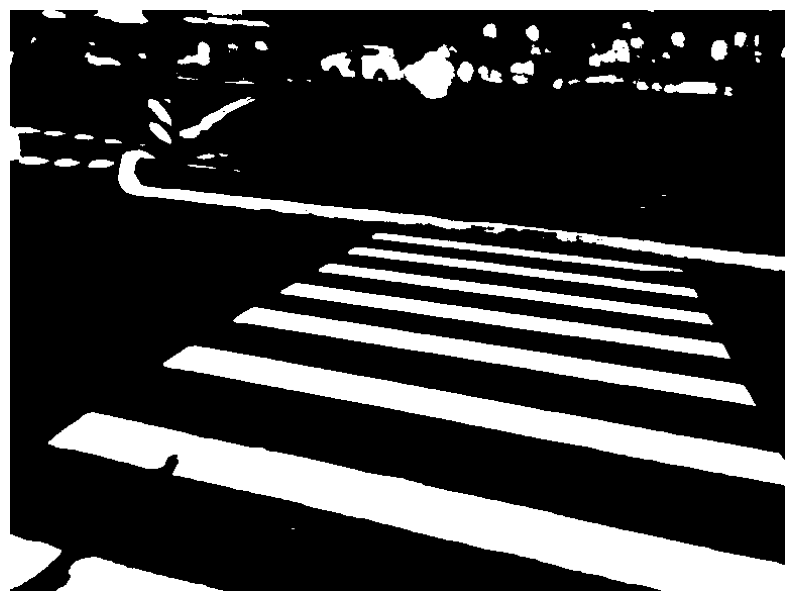

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('trial.png')

# 1. Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Apply thresholding to make pixels either black or white
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 3. Display the image as output of the cell
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()


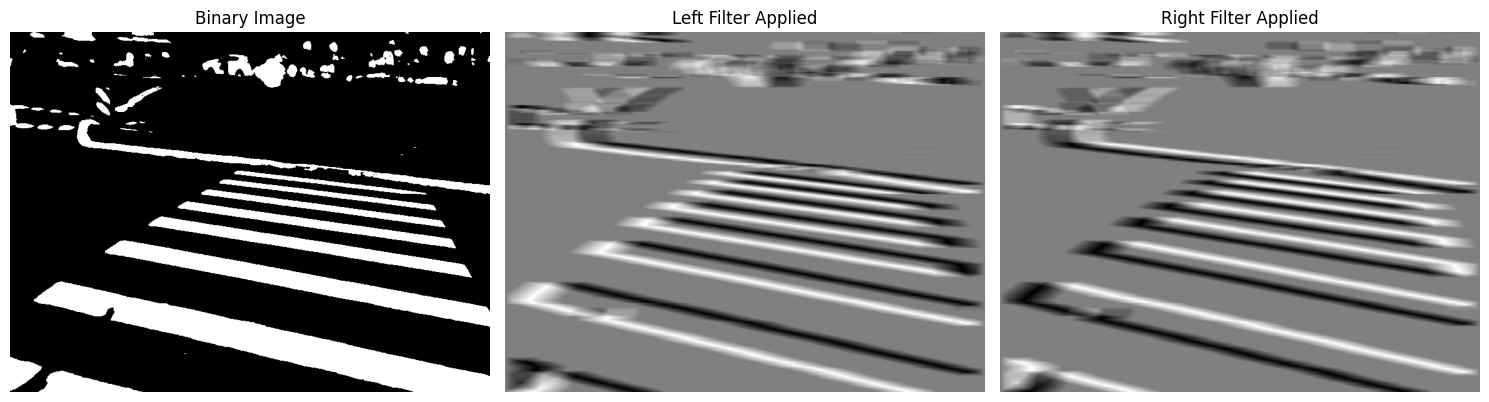

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('trial.png')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to make pixels either black or white
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Create the left filter
filterleft = np.ones((1, 100), dtype=np.float32)
filterleft[:, :50] = -1

# Create the right filter
filterright = -filterleft

# Apply the filters
result_left = cv2.filter2D(binary.astype(np.float32), -1, filterleft)
result_right = cv2.filter2D(binary.astype(np.float32), -1, filterright)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(result_left, cmap='gray')
plt.title('Left Filter Applied')
plt.axis('off')

plt.subplot(133)
plt.imshow(result_right, cmap='gray')
plt.title('Right Filter Applied')
plt.axis('off')

plt.tight_layout()
plt.show()




In [7]:
### visualize max of filters:

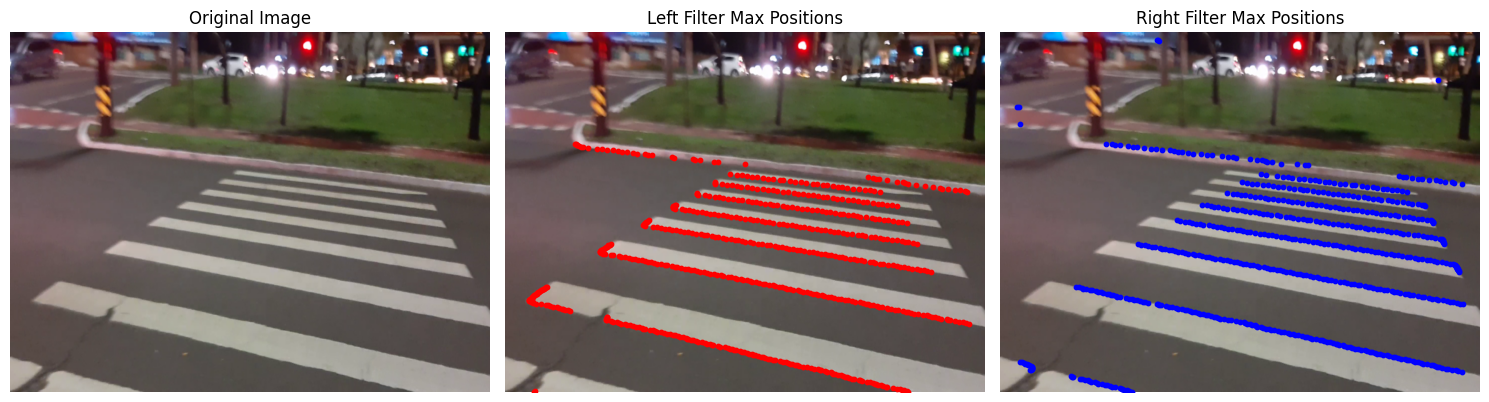

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already run the code you provided

# Find the positions of the maximum values
max_left = np.max(result_left)
max_right = np.max(result_right)

positions_left = np.where(result_left == max_left)
positions_right = np.where(result_right == max_right)

# Create a visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

# Left filter max positions
ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax2.scatter(positions_left[1], positions_left[0], color='red', s=10)
ax2.set_title('Left Filter Max Positions')
ax2.axis('off')

# Right filter max positions
ax3.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax3.scatter(positions_right[1], positions_right[0], color='blue', s=10)
ax3.set_title('Right Filter Max Positions')
ax3.axis('off')

plt.tight_layout()
plt.show()
